In [2]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from IPython.display import Image, display

In [3]:
llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai")

In [4]:
# Create Tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

# This will be a tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

In [5]:
# Create LLM that can call tools 
tools = [add, multiply, divide]
llm_with_tools = llm.bind_tools(tools)

In [6]:
sys_msg = SystemMessage(content="Use either tools to perform arithmetic on a set of inputs or just give me answer with your knowledge")
# Node to call LLM
def tool_calling_llm(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}



In [9]:
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))   # Node to call tools

# Define edges: these determine how the control flow moves
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools", "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
react_graph = builder.compile()

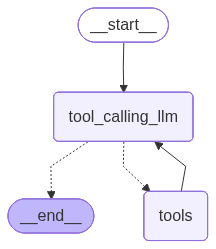

In [10]:
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [11]:
messages = [HumanMessage(content="Add 343433 and 4232323 then divide the result by 10")]
messages = react_graph.invoke({"messages": messages})

In [12]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 343433 and 4232323 then divide the result by 10
================================== Ai Message ==================================
Tool Calls:
  add (cbc4a9f2-a597-4065-beeb-bc4e0c37313f)
 Call ID: cbc4a9f2-a597-4065-beeb-bc4e0c37313f
  Args:
    a: 343433
    b: 4232323
================================= Tool Message =================================
Name: add

4575756
================================== Ai Message ==================================
Tool Calls:
  divide (9cdfedd6-ad61-4355-8479-88d1669fda78)
 Call ID: 9cdfedd6-ad61-4355-8479-88d1669fda78
  Args:
    b: 10
    a: 4575756
================================= Tool Message =================================
Name: divide

457575.6
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The answer is 457575.6', 'extras': {'signature': 'CuABAXLI2nw3tT3myLorpAje19A9bRpFzBp68aLRzdpsmjI3A7ftPAofK7iS

In [13]:
messages = [HumanMessage(content="What is the capital of Spain?")]
messages = react_graph.invoke({"messages": messages})


for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the capital of Spain?
================================== Ai Message ==================================

[{'type': 'text', 'text': 'The capital of Spain is Madrid.', 'extras': {'signature': 'CqICAXLI2ny91Yp6RR7FaiIgvufu1XFD7AuC358Yqa8ok8GuXU414T2nzLwKURVa5eDJmeuiaOIDj1ISy/dw2xrzPmVlF2hQTzRLZQW1ghztO26u5NvbhrSugunBbTc0DKoDUb1Lm2hlmB7gW0x38GUAffPq3/LIHZAa9nftPNtg1RVyhqqmMFUk2QeyhedXXjNnrIquqvYbSRwwwJQL5Vnr6INECjIvN63GH0WiBGrvMYZqWbERCBoYs3kBv2w25D6xSiHNKbfjRSP7RhbeUqF/AzuadlzsmU53eY5AZxgTnB/Ya2ZQaQgsu5TxDSsVEMmyZzDzOXL6N6zFErjOayG0ctgUnuoPPX+GJslgLsJAIhZiqT6YPcQNgHsBrMSoVvvxPuo='}}]
